# <h1><b><I> General Setup

## Imports and general setup

In [1]:
import os, sys, time
from tqdm import tqdm
sys.path.append("gammabayes/BFCalc/")
sys.path.append("gammabayes")

# from gammabayes.BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from gammabayes.utils.utils import log_bkg_CCR_dist, interpolate, special, integrate
from gammabayes.utils.event_axes import log10eaxistrue, longitudeaxistrue, latitudeaxistrue, log10eaxis, longitudeaxis, latitudeaxis
# from gammabayes.utils.utils import inverse_transform_sampling
from gammabayes.hyperparameter_likelihood import hyperparameter_likelihood
from gammabayes.prior import discrete_logprior
from gammabayes.likelihood import discrete_loglikelihood
from gammabayes.utils.utils import log_edisp, log_psf
from gammabayes.utils.utils import psf_efficient, edisp_efficient, log_edisp, log_psf, single_loglikelihood
from gammabayes.SingleChannel_DM_Prior import DM_dist


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools, random
from multiprocessing import Pool, freeze_support
import multiprocessing
import pandas as pd

random.seed(0)


/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
0.47027777777777774*(8/16)*(1e7/1e3)*(1/100)

23.513888888888886

In [3]:
astrophysicalbackground = np.load("gammabayes/package_data/unnormalised_astrophysicalbackground.npy")
psfnormalisationvalues = np.load("gammabayes/package_data/psfnormalisation.npy")
edispnormalisationvalues = np.load("gammabayes/package_data/edispnormalisation.npy")


In [4]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

logjacobtrue = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]


print(lonmeshtrue.shape, lonmeshrecon.shape)

(601, 35, 30) (35, 30)


## Script Parameter Setup

In [5]:
numberoftruevaluesamples = int(1e3)
Nsamples=numberoftruevaluesamples
truelambda          = 0.8
nsig                = int(round(truelambda*Nsamples))
nbkg                = int(round((1-truelambda)*Nsamples))

truelambda          = nsig/(nbkg+nsig)
numcores            = 6
truelogmass         = 1.2

startertimer = time.perf_counter()
print(startertimer)

4.37165675


# <h1><b>Simulation

## Setup

### Background setup

In [6]:
unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(log_bkg_CCR_dist(log10emeshtrue, lonmeshtrue,latmeshtrue)),np.log(astrophysicalbackground))


logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues+logjacobtrue)

logbkgpriorvalues.shape


nuisancemesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(log_bkg_CCR_dist(*nuisancemesh)),np.log(astrophysicalbackground))
# unnormed_logbkgpriorvalues = np.squeeze(log_bkg_CCR_dist(*nuisancemesh))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)

### Signal Setup

In [7]:
DM_dist_instance= DM_dist(longitudeaxistrue, latitudeaxistrue, channel='W')
logDMpriorfunc = DM_dist_instance.func_setup()

In [8]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='W channel Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(truelogmass,), hyperparameter_names=['mass'], logjacob=logjacobtrue)
DM_prior

(1.2,)


discrete log prior class
----------------------------
name = W channel Dark Matter Prior
logfunction type is <function DM_dist.func_setup.<locals>.DM_signal_dist at 0x7ff318f55d30>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

## True Value Simulation

In [9]:
if truelambda!=0.0:
    siglogevals,siglonvals,siglatvals  = DM_prior.sample(nsig)
else:
    siglogevals = np.asarray([])
    siglonvals = np.asarray([])
    siglatvals = np.asarray([])

In [10]:

if truelambda!=1.0:
    bkglogevals,bkglonvals,bkglatvals  = bkg_prior.sample(nbkg)
else:
    bkglogevals = np.asarray([])
    bkglonvals = np.asarray([])
    bkglatvals = np.asarray([])

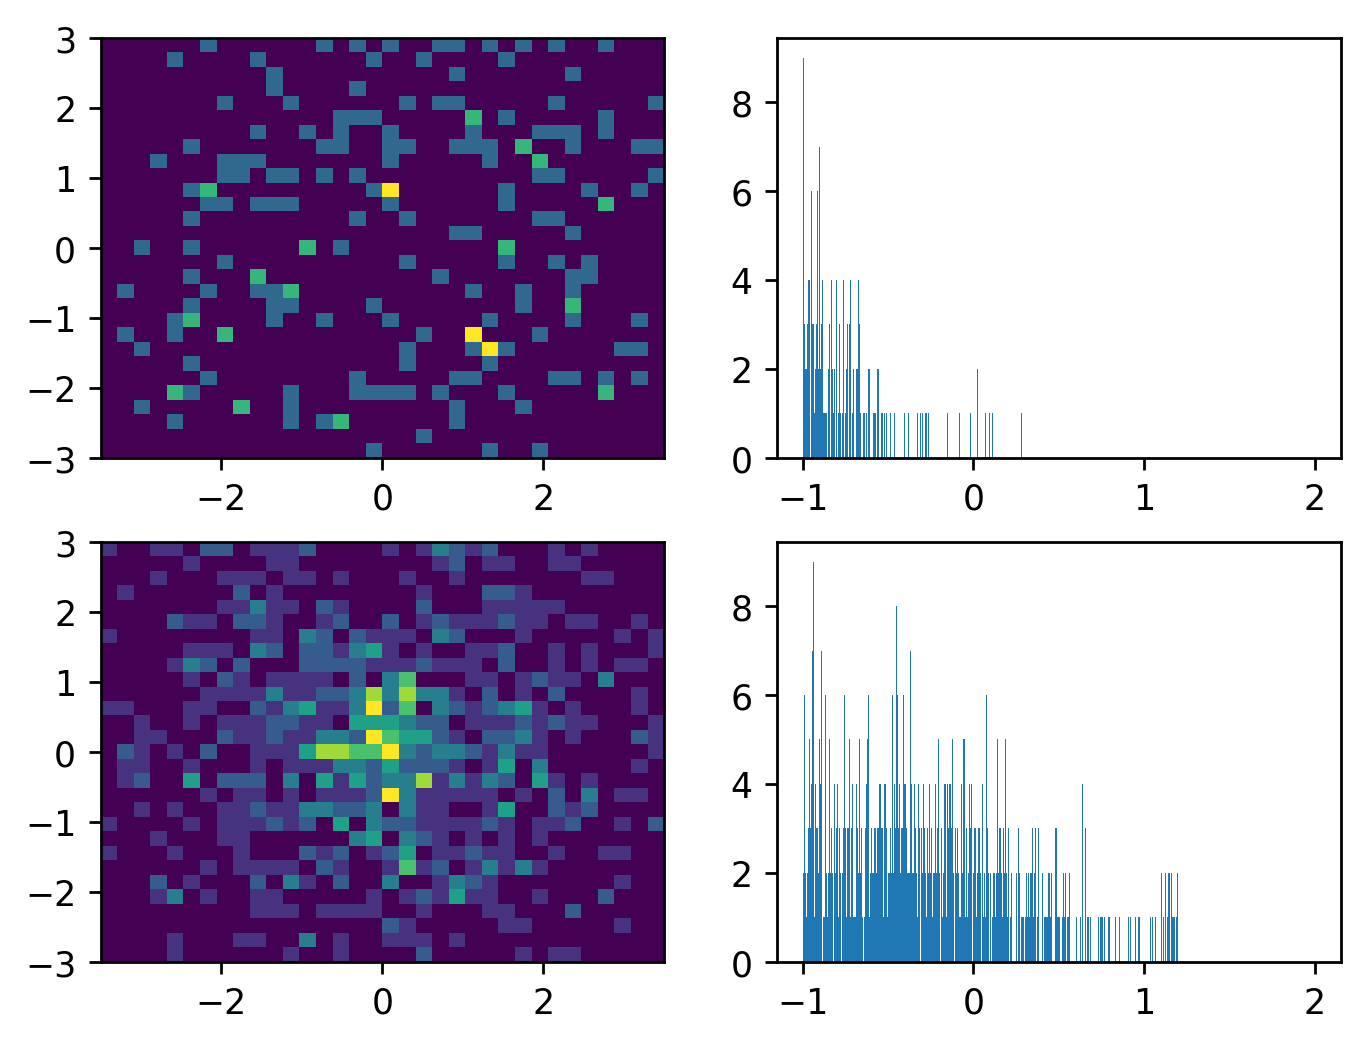

In [11]:
plt.figure(dpi=250)
plt.subplot(221)
plt.hist2d(bkglonvals, bkglatvals, bins=(longitudeaxistrue, latitudeaxistrue))

plt.subplot(222)
plt.hist(bkglogevals, bins=log10eaxistrue)

plt.subplot(223)
plt.hist2d(siglonvals,siglatvals, bins=(longitudeaxistrue, latitudeaxistrue))

plt.subplot(224)
plt.hist(siglogevals, bins=log10eaxistrue)
plt.show()

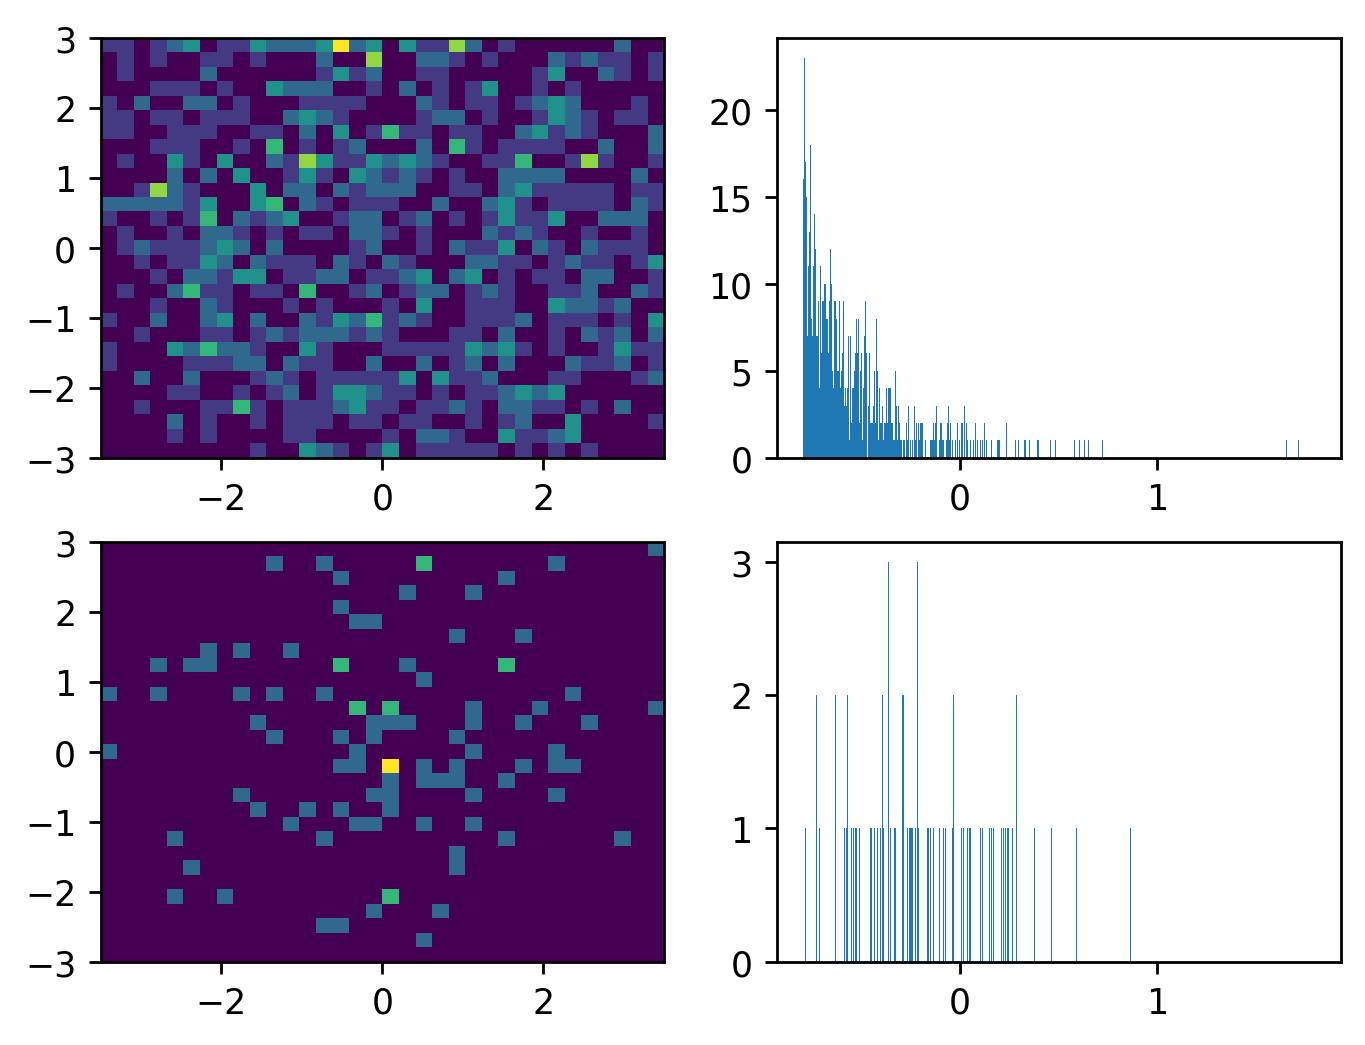

## Reconstructed Value Simulation

In [12]:
logjacob = np.meshgrid(np.log(10**log10eaxis), longitudeaxis, latitudeaxis, indexing='ij')[0]

In [13]:
logjacob = np.log(10**log10eaxis)
edisp_like = discrete_loglikelihood(logfunction=log_edisp, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])

Number of input dimensions 1


In [14]:
psf_like = discrete_loglikelihood(logfunction=log_psf, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function log_psf at 0x7ff2fb89b040>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

### Signal

In [15]:

if truelambda!=0.0:
    # sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    signal_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
else:
    signal_log10e_measured = np.asarray([])

100%|██████████| 800/800 [00:00<00:00, 1411.61it/s]


In [16]:

signal_lon_measured = []
signal_lat_measured = []

if truelambda!=0:
    
    sig_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    
    for sig_lonlat_psf_sample in sig_lonlat_psf_samples:
        signal_lon_measured.append(sig_lonlat_psf_sample[0])
        signal_lat_measured.append(sig_lonlat_psf_sample[1])

100%|██████████| 800/800 [00:05<00:00, 154.15it/s]


### Background

In [17]:
if truelambda!=1.0:
    # sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    bkg_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]
else:
    bkg_log10e_measured = np.asarray([])

100%|██████████| 200/200 [00:00<00:00, 1515.78it/s]


In [18]:
bkg_lon_measured = []
bkg_lat_measured = []

if truelambda!=0:
    
    bkg_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]
    
    for bkg_lonlat_psf_sample in bkg_lonlat_psf_samples:
        bkg_lon_measured.append(bkg_lonlat_psf_sample[0])
        bkg_lat_measured.append(bkg_lonlat_psf_sample[1])


100%|██████████| 200/200 [00:01<00:00, 154.69it/s]


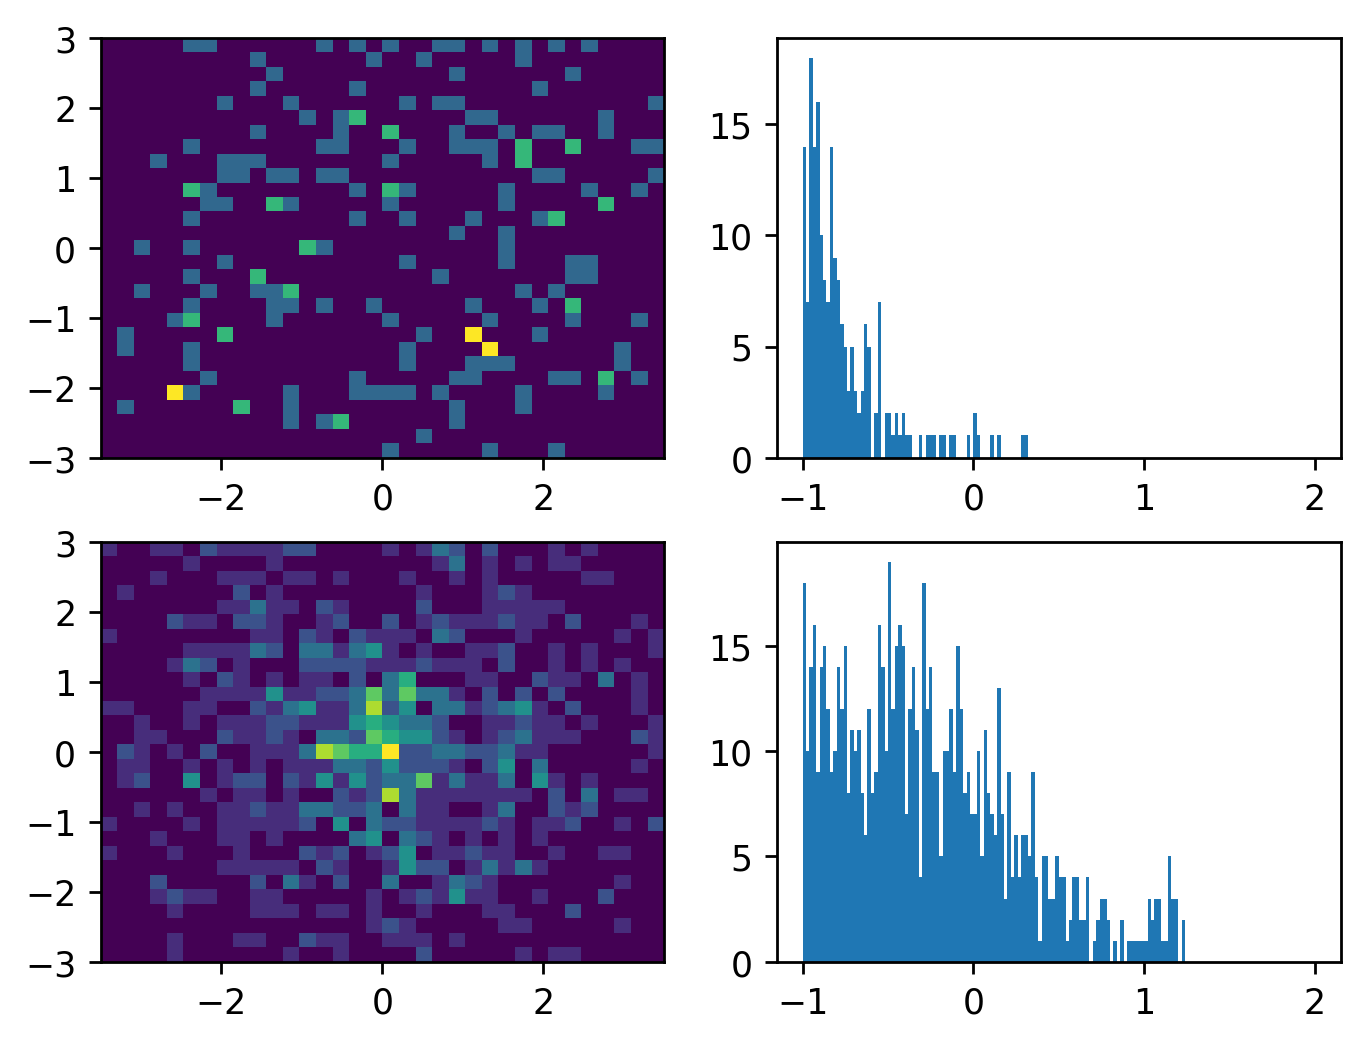

In [19]:
plt.figure(dpi=250)
plt.subplot(221)
plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=(longitudeaxis, latitudeaxis))

plt.subplot(222)
plt.hist(bkg_log10e_measured, bins=log10eaxis)

plt.subplot(223)
plt.hist2d(signal_lon_measured,signal_lat_measured, bins=(longitudeaxis, latitudeaxis))

plt.subplot(224)
plt.hist(signal_log10e_measured, bins=log10eaxis)
plt.show()

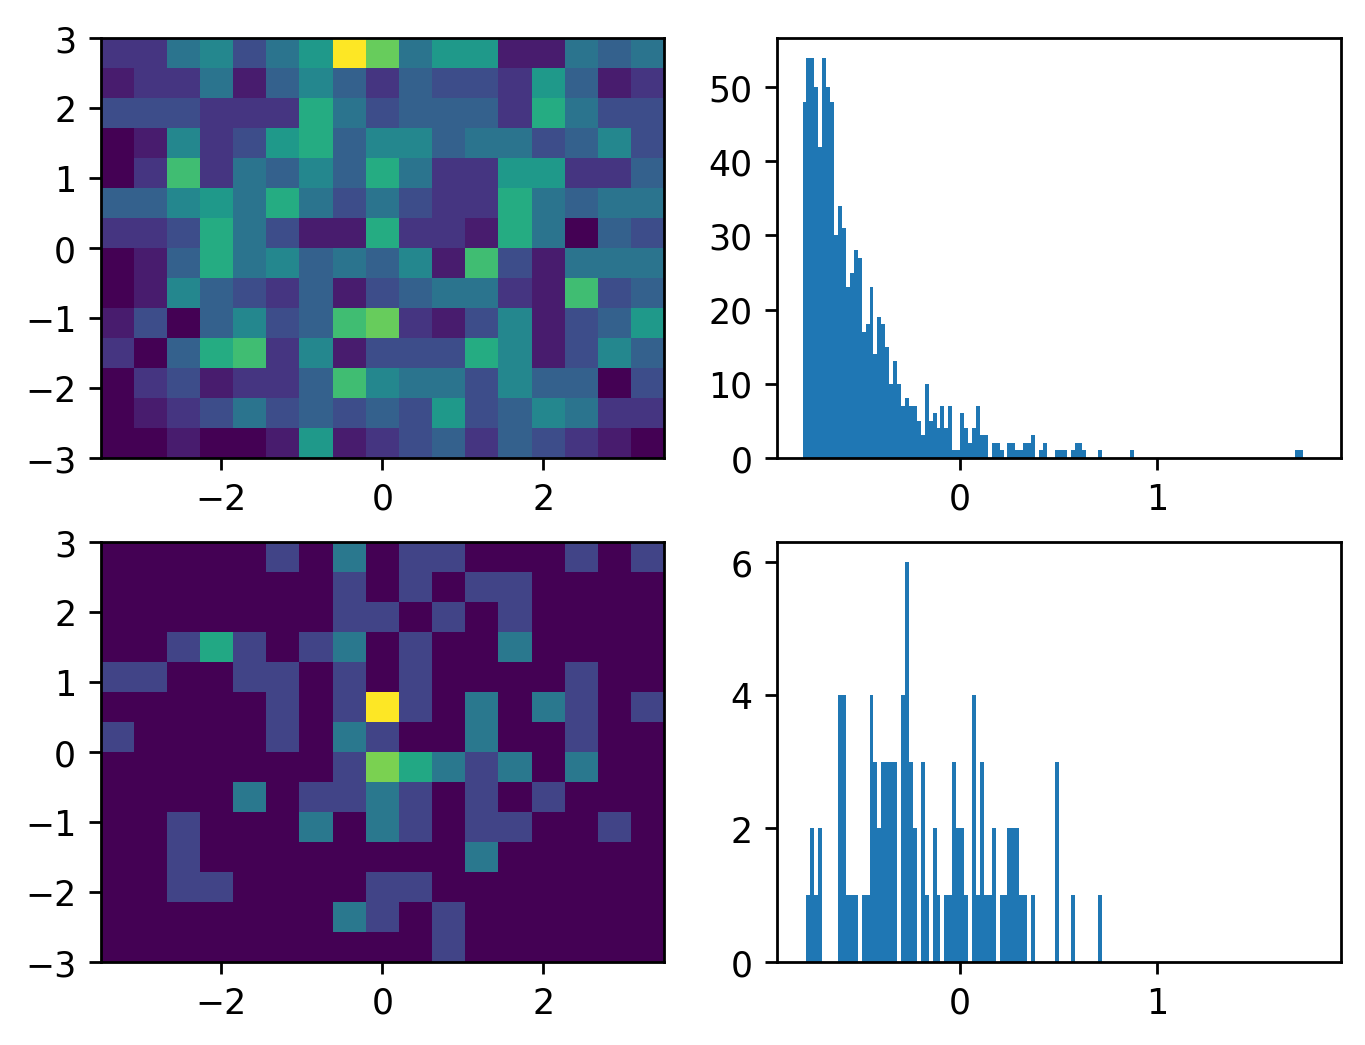

## Final simulation output

In [20]:


try:
    measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
    measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)
    
except:
    if type(bkg_log10e_measured)==np.float64:
        measured_log10e = list(signal_log10e_measured)
        measured_lon = list(signal_lon_measured)
        measured_lat = list(signal_lat_measured)
        measured_log10e.append(bkg_log10e_measured)
        measured_lon.append(bkg_lon_measured)
        measured_lat.append(bkg_lat_measured)
        
    elif type(signal_log10e_measured)==np.float64:
        measured_log10e = list(bkg_log10e_measured)
        measured_lon = list(bkg_lon_measured)
        measured_lat = list(bkg_lat_measured)
        measured_log10e.append(signal_log10e_measured)
        measured_lon.append(signal_lon_measured)
        measured_lat.append(signal_lat_measured)
    else:
        print('what')

# <h1><b>Analysis

## Marginalisation

In [21]:
nbinslogmass=51

if nsig is None:
    nsig = len(list(measured_log10e))

logmasswindowwidth      = 2/np.sqrt(nsig)

logmasslowerbound       = truelogmass-logmasswindowwidth
logmassupperbound       = truelogmass+logmasswindowwidth

# if 1:
if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 

In [22]:
hyperparameter_likelihood_instance = hyperparameter_likelihood(priors=(DM_prior, bkg_prior,), likelihood=single_loglikelihood, 
                                                               dependent_axes=(log10eaxistrue,  longitudeaxistrue, latitudeaxistrue), dependent_logjacob=logjacobtrue,
                                                               hyperparameter_axes = ((logmassrange,), (None,)), numcores=8, likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)

measured_log10e = [float(measured_log10e_val) for measured_log10e_val in measured_log10e]
margresults = hyperparameter_likelihood_instance.full_obs_marginalisation(axisvals= (measured_log10e, measured_lon, measured_lat))

Setting up prior matrices:   0%|          | 0/2 [00:00<?, ?it/s]

Setting up prior matrices: 100%|██████████| 2/2 [01:03<00:00, 31.68s/it]
Performing parallelized direct event marginalisation: 100%|██████████| 1000/1000 [00:00<00:00, 167705.08it/s]
/Users/lpin0002/Desktop/AlternateBranchDir/GammaBayes/gammabayes/utils/utils.py:106: RuntimeWarning: divide by zero encountered in log
  output = np.log(psffull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/Desktop/AlternateBranchDir/GammaBayes/gammabayes/utils/utils.py:110: RuntimeWarning: divide by zero encountered in log
  output+=np.log(edispfull.evaluate(energy_true=10**logetrue*u.TeV,


In [23]:
margresultsarray = np.array(margresults)
sigmargresults = np.squeeze(np.vstack(margresultsarray[:,0])).T
bkgmargresults = np.squeeze(np.vstack(margresultsarray[:,1]))
sigmargresults.shape

(51, 1000)

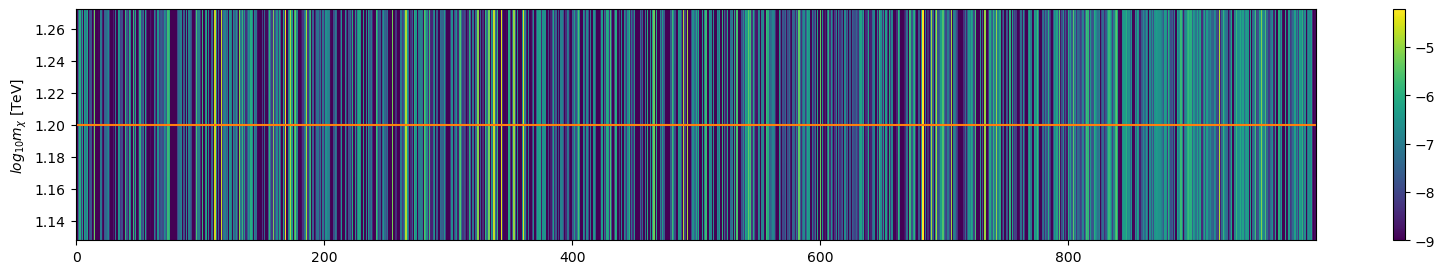

In [24]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(Nsamples)), logmassrange, indexing='ij'), 
               sigmargresults.T-special.logsumexp(sigmargresults, axis=1), 
               cmap='viridis', vmin=-9)
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(truelogmass, c='tab:orange')
plt.colorbar()
plt.show()

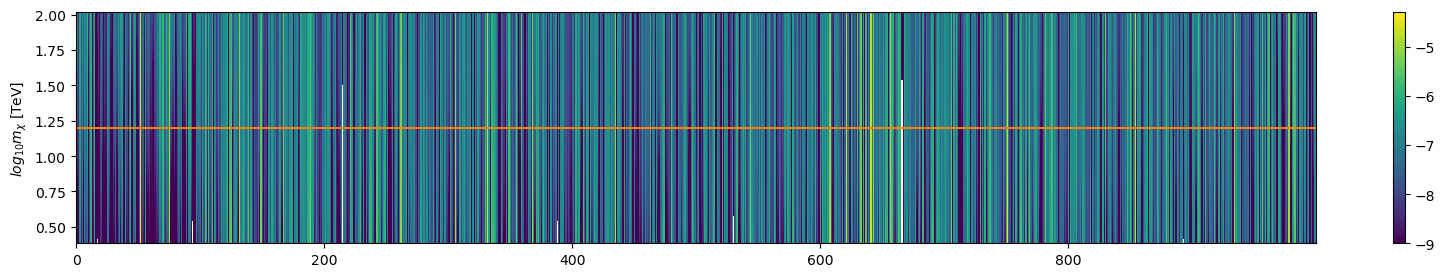

## Calculating posterior

In [25]:

nbinslambda            = 81
lambdawindowwidth      = 9/np.sqrt(Nsamples)


lambdalowerbound       = truelambda-lambdawindowwidth
lambdaupperbound       = truelambda+lambdawindowwidth




if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, nbinslambda) 

original_log_posterior = []

for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
    original_log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+sigmargresults[logmassindex,:], np.log(1-lambdaval)+bkgmargresults)) for logmassindex in range(len(list(logmassrange)))])

original_log_posterior = np.array(original_log_posterior)-special.logsumexp(original_log_posterior)
new_log_posterior = hyperparameter_likelihood_instance.create_mixture_log_posterior(
    mixture_axes=(lambdarange, 1-lambdarange), log_margresults=margresultsarray)

new_log_posterior = new_log_posterior - special.logsumexp(new_log_posterior)

endertimer = time.perf_counter()
print(endertimer-startertimer)

100%|██████████| 81/81 [00:00<00:00, 550.75it/s]


Reshaped mixture shape: (2, 1000)
reshaped_log_margresults[0,:]: [array([-12.96419394, -12.96048667, -12.95522747, -12.95155088,
        -12.94798128, -12.94267924, -12.93911288, -12.93389256,
        -12.93036395, -12.92523022, -12.92174898, -12.91838084,
        -12.91323287, -12.90987934, -12.90481072, -12.90151825,
        -12.89656899, -12.89321071, -12.88982509, -12.88462585,
        -12.88126918, -12.87614262, -12.87279042, -12.86770301,
        -12.86436153, -12.85934851, -12.85604038, -12.85283737,
        -12.84783843, -12.84465918, -12.83971086, -12.83654686,
        -12.83167075, -12.82857141, -12.82557381, -12.82072782,
        -12.81775448, -12.81298783, -12.81004766, -12.80535204,
        -12.80241454, -12.7995727 , -12.79485076, -12.79204398,
        -12.78740142, -12.78463454, -12.78007455, -12.77732629,
        -12.77466977, -12.77009609, -12.76747994])
 array([-11.42738312, -11.42546413, -11.42195622, -11.42007687,
        -11.41826962, -11.41476793, -11.41297446, -1

In [26]:
# log_posterior=np.squeeze(new_log_posterior)
log_posterior = original_log_posterior

# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_34500/4116894507.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


0.002490240239554724
0.0015324555320336782
0.000766227766016841
0.0009577847075210459
0.0017240124735378834
0.0024902402395547206


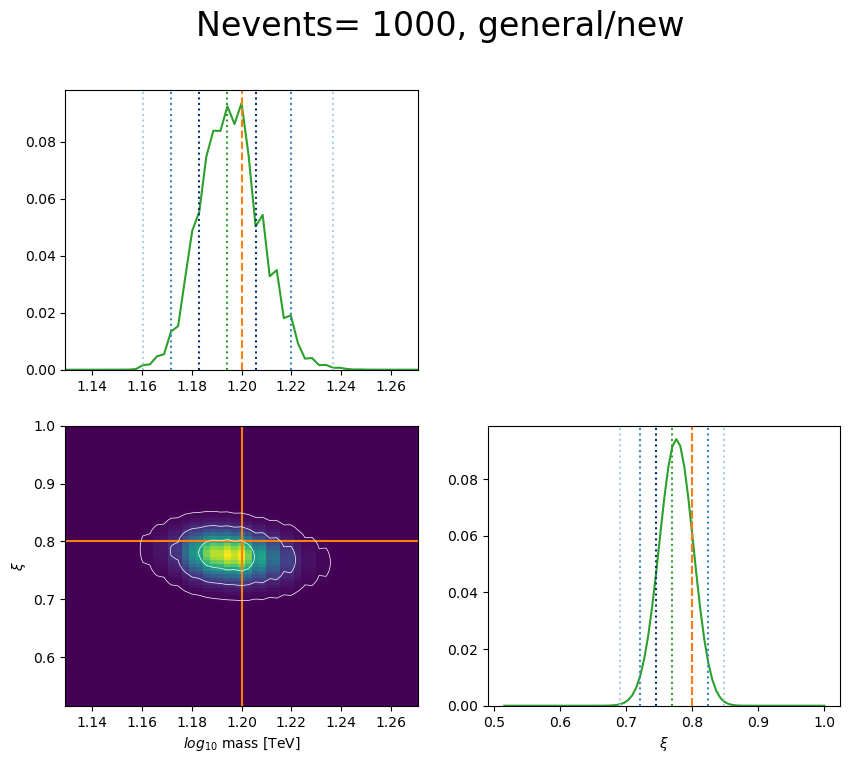

In [27]:
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {Nsamples}, general/new", size=24)

# Upper left plot
logmass_logposterior = special.logsumexp(log_posterior, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(truelogmass, ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10eaxistrue[1]-log10eaxistrue[0]:
    for logetrueval in log10eaxistrue:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(log_posterior), vmin=0)
ax[1,0].axvline(truelogmass, c='tab:orange')
ax[1,0].axhline(truelambda, c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\xi$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
normed_posterior = np.exp(log_posterior)/np.exp(log_posterior).sum()
n = 100000
t = np.linspace(0, normed_posterior.max(), n)
integral = ((normed_posterior >= t[:, None, None]) * normed_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(normed_posterior, t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


lambda_logposterior = special.logsumexp(log_posterior, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlambda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()]
    lambdapercentiles.append(lambdapercentile)
    print(np.sqrt(1e5/1e8)*np.abs(lambdapercentile - meanlambda))





ax[1,1].plot(lambdarange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(truelambda, ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\xi$')
ax[1,1].set_ylim([0, None])


# plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{truelogmass}_l{truelambda}_%m%d_%H%M.pdf"))
plt.show()

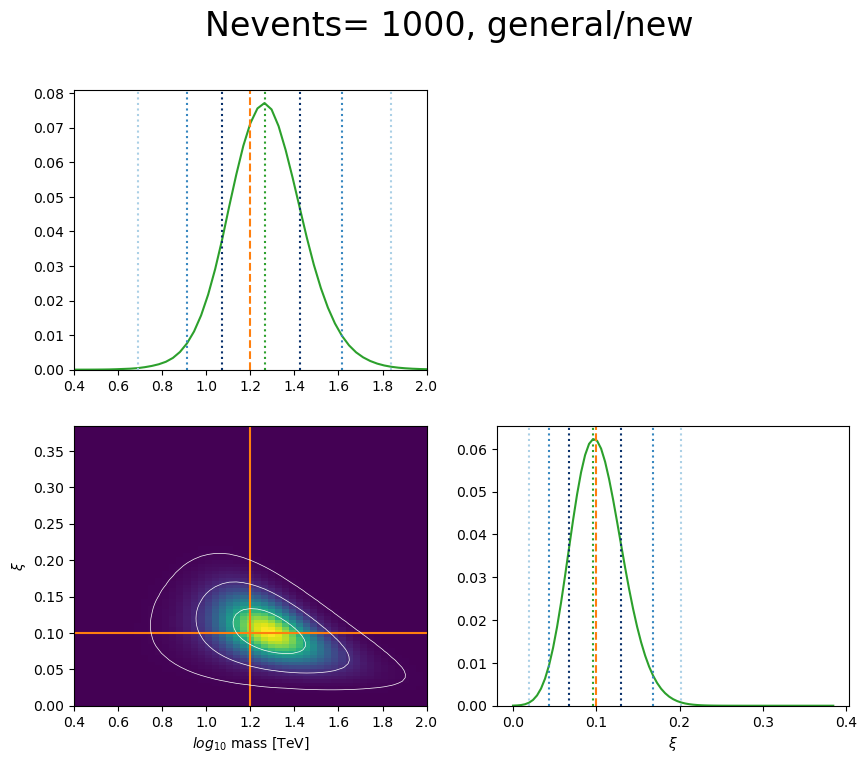

In [28]:
os.system('say Your code is finished.')


0

In [29]:
darkSUSY_BFs_cleaned = pd.read_csv('gammabayes/BFCalc/darkSUSY_BFs/darkSUSY_BFs_cleaned.csv', delimiter=' ')

darkSUSY_massvalues = darkSUSY_BFs_cleaned.iloc[:,1]/1e3

darkSUSY_lambdavalues = darkSUSY_BFs_cleaned.iloc[:,2]

In [30]:
vals = darkSUSY_BFs_cleaned.to_numpy()[:,20]
np.quantile(vals[vals>0], 0.), np.quantile(vals[vals>0], 0.25), np.quantile(vals[vals>0], 0.5), np.quantile(vals[vals>0], 0.75), np.quantile(vals[vals>0], 1.)

(2.2349773303336054e-39,
 7.53586915875424e-34,
 1.2459396982278596e-31,
 2.09150247236128e-29,
 3.2476038598229974e-19)

In [31]:

import numpy as np
testaarry = np.linspace(0,1,11)
testaarry2 = np.linspace(0,2,11)


testaarry*testaarry2

array([0.  , 0.02, 0.08, 0.18, 0.32, 0.5 , 0.72, 0.98, 1.28, 1.62, 2.  ])